In [1]:
import scanpy as sc
import pandas as pd
import infercnvpy as cnv
import numpy as np  

import sys
import os 
sys.path.append(os.path.expanduser(f"~/SSS_mount/insituCNV/InSituCNV"))
import insitucnv as icv

# CosMx CNV inference

### Read in dataset

In [2]:
sid = '221'

In [3]:
adata = sc.read(os.path.expanduser(f"~/SSS_mount/insituCNV/data/WTx-CosMx_TVA/round2/{sid}/adata_{sid}_processed_1.h5ad"))

In [4]:
adata

AnnData object with n_obs × n_vars = 347023 × 18545
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_local_px', 'CenterY_local_px', 'Width', 'Height', 'Mean.PanCK', 'Max.PanCK', 'Mean.CD68_CK8_18', 'Max.CD68_CK8_18', 'Mean.CD298_B2M', 'Max.CD298_B2M', 'Mean.CD45', 'Max.CD45', 'Mean.DAPI', 'Max.DAPI', 'cell_id', 'Dash', 'ISH.concentration', 'Panel', 'Run_Tissue_name', 'Run_name', 'assay_type', 'dualfiles', 'tissue', 'version', 'slide_ID', 'CenterX_global_px', 'CenterY_global_px', 'cell_ID', 'unassignedTranscripts', 'median_RNA', 'RNA_quantile_0.75', 'RNA_quantile_0.8', 'RNA_quantile_0.85', 'RNA_quantile_0.9', 'RNA_quantile_0.95', 'RNA_quantile_0.99', 'nCount_RNA', 'nFeature_RNA', 'median_negprobes', 'negprobes_quantile_0.75', 'negprobes_quantile_0.8', 'negprobes_quantile_0.85', 'negprobes_quantile_0.9', 'negprobes_quantile_0.95', 'negprobes_quantile_0.99', 'nCount_negprobes', 'nFeature_negprobes', 'median_falsecode', 'falsecode_quantile_0.75', 'falsecode_quantile_0.8', 'falsecode_quantil

In [5]:
# Subset to only contain the common genes across snPATHO-seq and CosMx for comparison

common_genes_df = pd.read_csv("snPATHO-seq/221_common_genes.csv")
common_genes_df.head()

adata = adata[:, adata.var_names.isin(common_genes_df['common_genes'])].copy()

,common_genes
0,PHYHIPL
1,MAPKAPK2
2,AGFG2
3,ELMO2
4,ACOT7


## Run CNV inference and epithelial clustering

  0%|          | 0/348 [00:00<?, ?it/s]

categories: 0, non-epi
var_group_labels: chr1, chr2, chr3, etc.


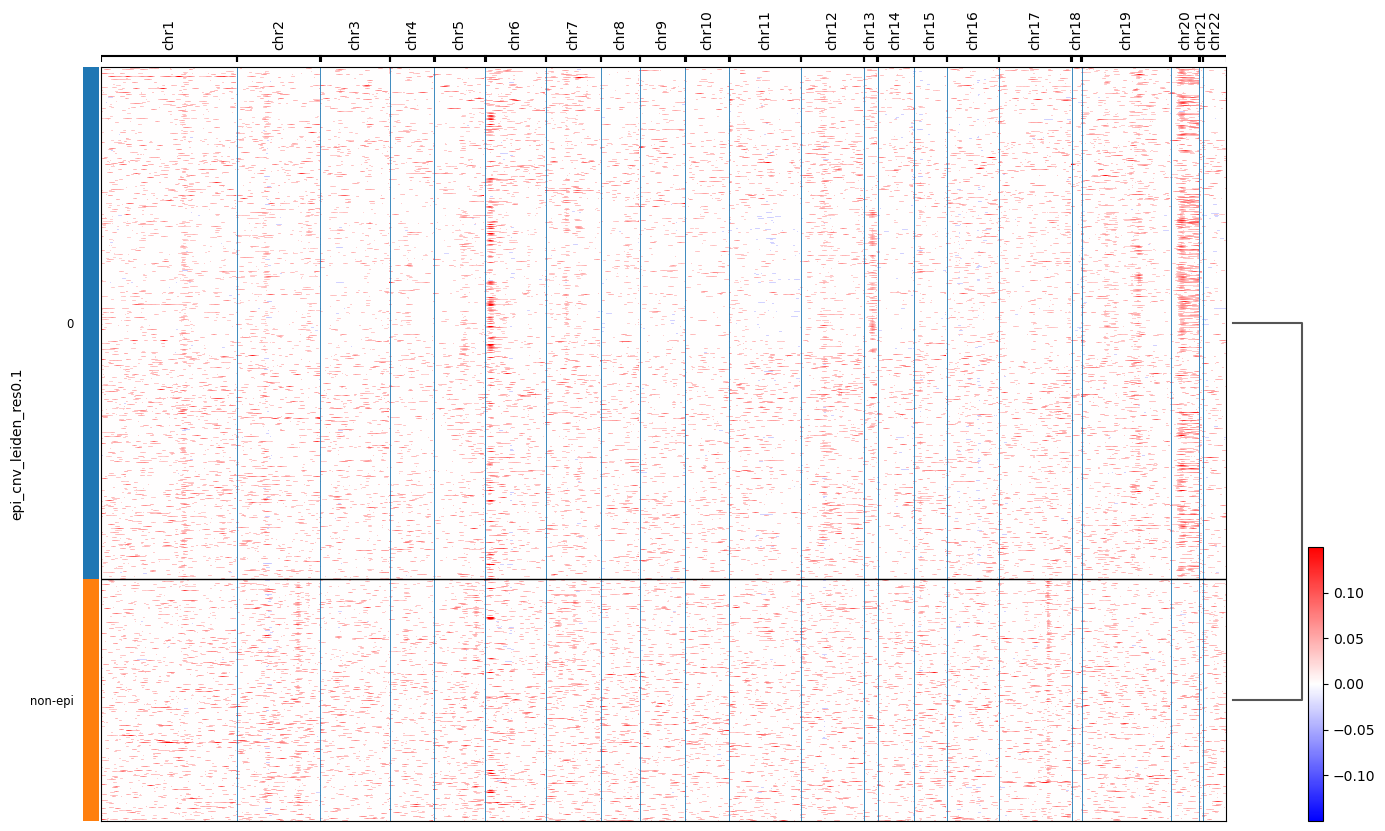

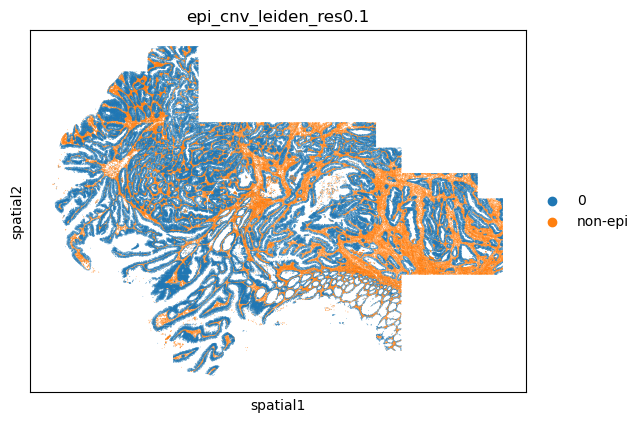

  0%|          | 0/348 [00:00<?, ?it/s]

categories: 0, 1, 2, etc.
var_group_labels: chr1, chr2, chr3, etc.


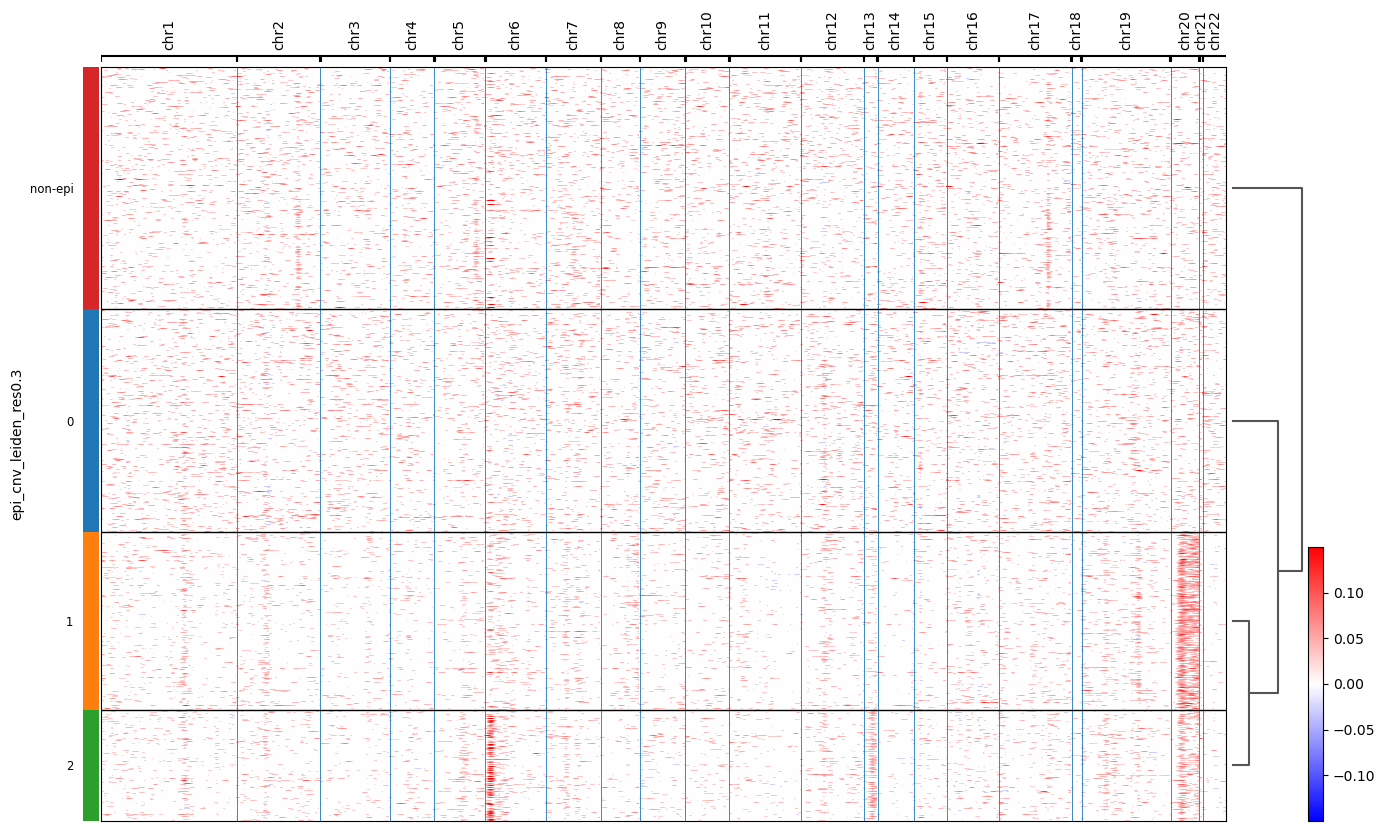

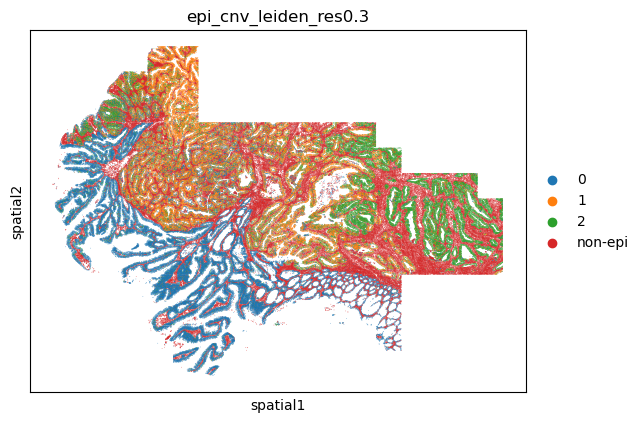

In [7]:
for res in [0.1, 0.3]:
    # log normalize the raw data before smoothing. 
    adata.X = adata.layers['raw'].copy()
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    
    # Compute CNV inference using the REF region of interest as reference and with a window-size of 100 
    cnv.tl.infercnv(adata, 
                    window_size =100,
                    reference_key = 'ROI_status',
                    reference_cat = ['REF'],
                    chunksize = 1000)
    
    # Select only the epithelial cells and compute dimentionality reduction and nearest neighbor graph based on their CNV profiles
    adata_epi = adata[adata.obs.add_sub == 'epi'].copy()
    cnv.tl.pca(adata_epi)
    cnv.pp.neighbors(adata_epi)
    key_added=f'epi_cnv_leiden_res{res}'
    cnv.tl.leiden(adata_epi, resolution = res, key_added=key_added)
    
    # Add clusters back to adata
    adata.obs[key_added] = "non-epi"
    adata.obs.loc[adata_epi.obs_names, key_added] = adata_epi.obs[key_added]
    adata.obs[key_added] = adata.obs[key_added].astype("category")
    
    # Plot and save
    sc.tl.dendrogram(adata, groupby=key_added)
    cnv.pl.chromosome_heatmap(adata, groupby=key_added, vmin=-.15, vmax=.15, dendrogram=True, save=f'_CosMx_221_common_genes_no_smooth_{key_added}.pdf')
    sc.pl.spatial(adata, color=key_added, spot_size=100, save=f'_CosMx_221_common_genes_no_smooth_{key_added}.pdf')

## Plot and save figure

In [14]:
adata.uns['epi_cnv_leiden_res0.3_colors'] = ['#677DB7', #0
                                             '#FF773D', # 1
                                             '#FFCD4E', #2
                                             #'#9B1D20',#3
                                             '#ada9b0'#non-epi
                                            ]

categories: 0, 1, 2, etc.
var_group_labels: chr1, chr2, chr3, etc.


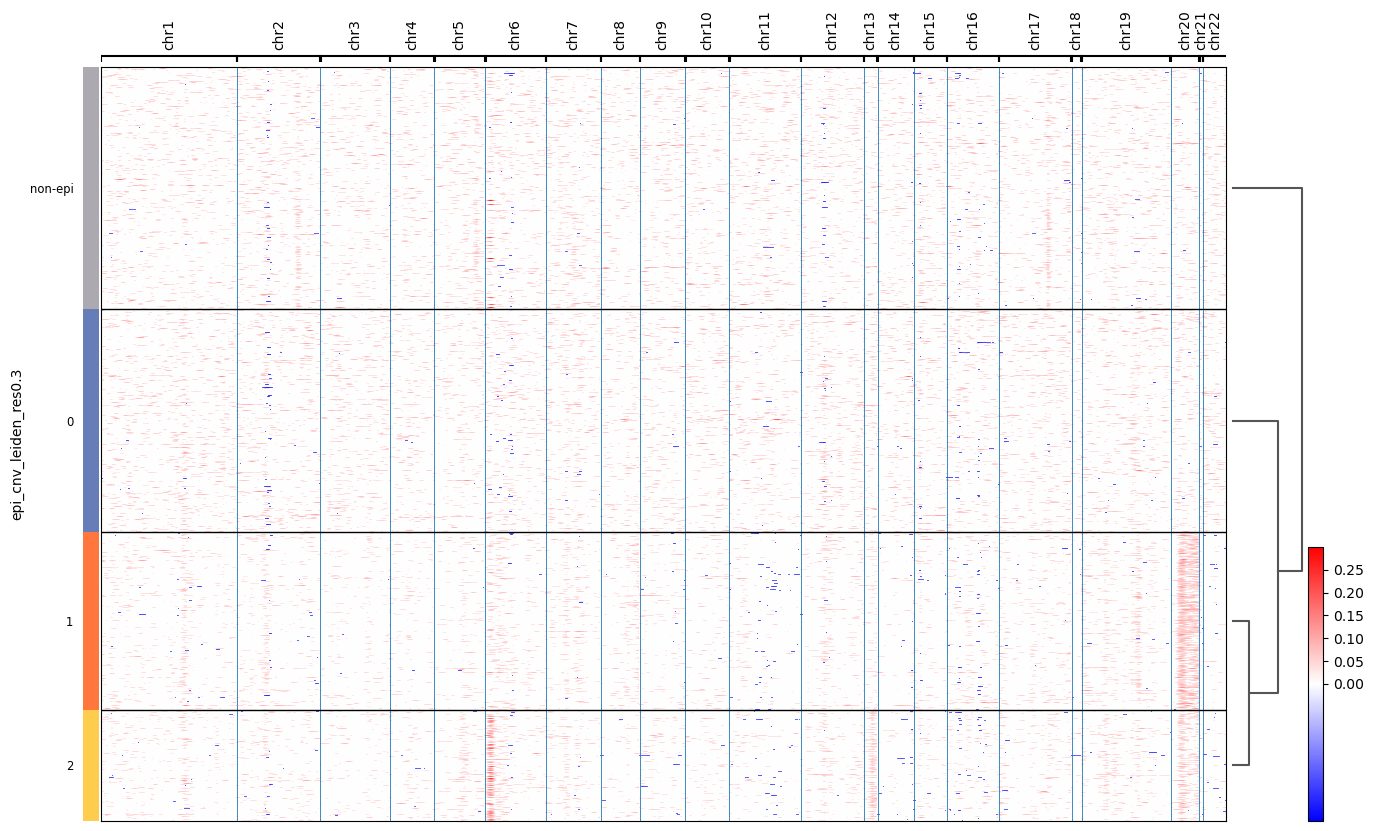

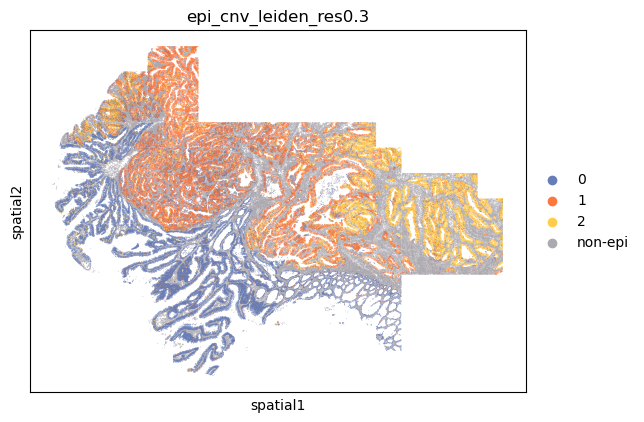

In [15]:
sid ='221'
groupby='epi_cnv_leiden_res0.3'
save = f'_CosMx_221_common_genes_no_smooth_{key_added}_fig.pdf'
# save_heatmap = None
cnv.pl.chromosome_heatmap(adata, groupby=groupby, dendrogram=True, save=save, vmax=0.3)
sc.pl.spatial(adata, color=groupby, spot_size=100, save=save)

## Save new adata object with CNV information

In [16]:
adata.write(os.path.expanduser(f"~/SSS_mount/insituCNV/data/WTx-CosMx_TVA/round2/221/CosMx_221_common_no_smooth_CNVinf.h5ad"), compression='gzip')